## Curate the dataset from Reddit comments and train the model to match anti-depressants with symptoms
In this notebook, I demonstrate how I trained the model to give recommendation given the symptoms. The idea here is to train a model in such a way that it maps an anti-depressant to symptoms that were alleviated by it. To acheive this, I've applied sentiment analysis to the text metioning the drugs and then used the score to weight the features. These features were then used to train the model (here I explored Bag-of-words, TF-IDF and Word2Vec) to classify top 5/10 mentioned drugs.

1. Load Reddit data and explore the data structure
2. Extract list of drugs
3. Create a corpus of drugs:comments about the drugs
4. Sentiment analysis
5. Train the model with CV and sentiment analysis score 

### 1. Load Reddit data and explore the data structure


In [253]:
import keras
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pandas as pd
import numpy as np
np.random.seed(2018)
import re
import json
import os 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import itertools
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.analys import * 
from src.data.text_analys import *
from src.models.CV_TF_Word2Vec_Anal import *
from src.models.LDA_topic_model import *
from src.features.build_features import *
from src.models.LinearSVC_Anal import *
from src.models.modelanalys import *
from src.features.build_features import *


In [274]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/mskang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [254]:
# Now let's take a look at this using pandas datafraem
tag = 'comm'
source = 'anti_dep'
with open('anti_dep_all_comm.json', 'r') as f:
    data = json.load(f)
df_subs = pd.DataFrame(data)

In [255]:
print(len(df_subs))

16310


In [256]:
len(df_subs.columns)

35

In [257]:
# Note that is far fewer than submission data 
print (df_subs.columns)

Index(['approved_at_utc', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_id', 'body', 'can_gild', 'can_mod_post',
       'collapsed', 'collapsed_reason', 'controversiality', 'created',
       'created_utc', 'edited', 'id', 'is_submitter', 'link_id', 'no_follow',
       'parent_id', 'permalink', 'removal_reason', 'retrieved_on', 'rte_mode',
       'score', 'send_replies', 'stickied', 'subreddit', 'subreddit_id'],
      dtype='object')


In [258]:
# Let's try couple of things 
print (df_subs[[ 'author', 'body','id', 'score'] ].head)

<bound method NDFrame.head of                     author                                               body  \
0              alliedeluxe  Try not to go into this thinking this is your ...   
1              trw377zxl9s  I didnt notice a change but now that ive cut m...   
2                 peri_dot  Thanks. I talked about it with him. I hope he ...   
3            Taylor8675309  I've tried celexa, lexapro, brintellix, and we...   
4             MariusPetran  I've heard that the Lexapro is acting well for...   
5                  EllaSue  Hey, are you still taking it? Has the anxiety ...   
6               dissodisor  I was afraid the side effects would affect my ...   
7               dissodisor  I social drank last night. Had allowed myself ...   
8              BigSteve201  I’m doing pretty well with it. I was super ner...   
9              BigSteve201  I’m doing pretty well with it. I was super ner...   
10             Cherblair98  Hey! TBH I haven't noticed any affects- positi...  

In [197]:
# OK - in this case, 'body' is what we're mining for: ad hoc information ['author', 'id', 'score'] 

In [259]:
filter_cols = [ 'author', 'body','id', 'score']

In [260]:
print (df_subs.head())

   approved_at_utc         author author_cakeday  \
0              NaN    alliedeluxe            NaN   
1              NaN    trw377zxl9s            NaN   
2              NaN       peri_dot            NaN   
3              NaN  Taylor8675309            NaN   
4              NaN   MariusPetran            NaN   

  author_flair_background_color author_flair_css_class author_flair_richtext  \
0                          None                   None                    []   
1                          None                   None                    []   
2                          None                   None                    []   
3                          None                   None                    []   
4                          None                   None                    []   

  author_flair_template_id author_flair_text author_flair_text_color  \
0                     None              None                    None   
1                     None              None                  

In [264]:
df_subs = df_subs.dropna(axis=1, how= 'all')

In [265]:
len(df_subs)

16310

In [268]:
df_subs.author_flair_type.unique()

array(['text', nan, 'richtext'], dtype=object)

In [269]:
df_subs.author_flair_text.unique()

array([None, 'Cymbalta ', 'fugitivepsychiatrist.com', 'Prozac', 'Effexor',
       'Celexa', 'Wellbutrin', 'Paxil', 'Trittico (Trazodone)', 'Zoloft',
       'sigh:sloth:', 'Prozac/Abilify', 'Lexapro',
       'vortioxetine • tianeptine', 'Trintellix',
       'Tapering off venlafaxine', 'Depression - Anxiety - Venlafaxine ',
       '(<>.<>)', 'mirtazapine 15mg', 'Effexor/Venlafaxine'], dtype=object)

### 2. Extract list of drugs

In [270]:
pills = pd.read_csv('antidepressants.txt')

In [271]:
pills['BrandName']= pills['Name'].str.split('\s+').str[0].str.strip()
print (pills['BrandName'])

0       Anafranil
1         Asendin
2         Aventyl
3          Celexa
4        Cymbalta
5         Desyrel
6          Elavil
7         Effexor
8           Emsam
9         Etrafon
10    fluvoxamine
11        Lexapro
12       Cipralex
13      Limbitrol
14       Ludiomil
15        Marplan
16         Nardil
17     nefazodone
18      Norpramin
19        Pamelor
20        Parnate
21          Paxil
22         Pexeva
23         Prozac
24        Remeron
25        Sarafem
26       Seroquel
27       Sinequan
28      Surmontil
29        Symbyax
30       Tofranil
31    Tofranil-PM
32        Triavil
33       Vivactil
34     Wellbutrin
35         Zoloft
36          Zyban
Name: BrandName, dtype: object


In [272]:
corp = pd.DataFrame(columns=pills.BrandName.values, index=['match_number'])
print(corp.columns)

Index(['Anafranil', 'Asendin', 'Aventyl', 'Celexa', 'Cymbalta', 'Desyrel',
       'Elavil', 'Effexor', 'Emsam', 'Etrafon', 'fluvoxamine', 'Lexapro',
       'Cipralex', 'Limbitrol', 'Ludiomil', 'Marplan', 'Nardil', 'nefazodone',
       'Norpramin', 'Pamelor', 'Parnate', 'Paxil', 'Pexeva', 'Prozac',
       'Remeron', 'Sarafem', 'Seroquel', 'Sinequan', 'Surmontil', 'Symbyax',
       'Tofranil', 'Tofranil-PM', 'Triavil', 'Vivactil', 'Wellbutrin',
       'Zoloft', 'Zyban'],
      dtype='object')


In [276]:
import re
# Getting rid of part without body
df_subs = df_subs[pd.notnull(df_subs['body'])]
print (len(df_subs))

# No Na anymore 
print (df_subs['body'].head().values)
print(df_subs['body'][df_subs['body'].str.contains(col,flags=re.IGNORECASE, regex=True)])
print (len(df_subs['body'][df_subs['body'].str.contains(col,flags=re.IGNORECASE, regex=True)]))

# Note that there may be users mentioning anafril twice?? 


Anafranil
16310
['Try not to go into this thinking this is your last resort. There will probably be something that works for you. I think a lot of us were worried to try SSRI’s, but I think many people here have really benefitted from them, including myself. I hope it works out for you. '
 'I didnt notice a change but now that ive cut my dose im definitely feeling how things were different with it.  Im going to go back on it or something else.'
 'Thanks. I talked about it with him. I hope he understands a bit better. I also hope it goes away this week'
 "I've tried celexa, lexapro, brintellix, and wellbutrin. Everything except wellbutrin has made me gain weight"
 "I've heard that the Lexapro is acting well for anxiety and have mild side effects.\nActually I'm on day 4 since I began this treatment for my GAD and SAD, well at first I have some mild side effects increased anxiety, some headaches, dizziness,a bit jittery too, but they are all mild"]
158     I was on anafranil for 3-4 month

In [222]:
# 14 mentions of Anafranil.. 

### 3. Create a corpus of drugs:comments about the drugs and analysis of the corpus

Analyze the frequency of drug mentioned in the comments --> Assumption: comment about a certain drug should mention the name of the drug: this ignores the possibility where the drug might have been alreay mentioned from the submissions; also didn't search for their generic names
 - 1 there are roughly top 5 drugs that are mentioned far more frequently than the other drugs 
 - 2 Map antidepressants:comments
 - 3 pipe out top5 and top10 mentioned drugs and munged data set into pickled/comm/{drugname}.pkl


In [277]:
# Collect'selftext' 'author' 'id' of submissions that contains any of drugs 
d_drug_ment_sub = {}

cwd = Path.cwd()
external_data_fd = '../data/external'
interim_data_fd ='../data/interim'
processed_data_fd = '../data/processed'
newpath_interim = r'{0}//reddit_corpus'.format((cwd/ interim_data_fd).resolve())
newpath_processed= r'{0}//reddit_corpus'.format((cwd/ processed_data_fd).resolve())

if not os.path.exists(newpath_interim):
    os.makedirs(newpath_interim)
if not os.path.exists(newpath_processed):
    os.makedirs(newpath_processed)
    
for drug_name in corp.columns:
    print ('\n')
    print (drug_name )
    d_drug_ment_sub[drug_name] = pd.DataFrame(columns=filter_cols)
    d_drug_ment_sub[drug_name][filter_cols]=df_subs[filter_cols][df_subs['body'].str.contains(drug_name,flags=re.IGNORECASE, regex=True)]
    print (len(d_drug_ment_sub[drug_name]))
    print ( "%f percent out of all comments " %(100*len(d_drug_ment_sub[drug_name])/len(df_subs)))
    print (d_drug_ment_sub[drug_name].describe())
    name = drug_name+'_mentioned_all'+tag+source 
    d_drug_ment_sub[drug_name].to_pickle(newpath_interim+"/%s.pkl"%(name))




Anafranil
14
0.085837 percent out of all comments 
       score
count   14.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0


Asendin
0
0.000000 percent out of all comments 
       score
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN


Aventyl
0
0.000000 percent out of all comments 
       score
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN


Celexa
188
1.152667 percent out of all comments 
            score
count  188.000000
mean     1.106383
std      0.473198
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      6.000000


Cymbalta
330
2.023299 percent out of all comments 
            score
count  330.000000
mean     1.118182
std      0.399052
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      4.000000


Desyrel
2
0.012262 percent out of all comments 
       score
count

6033


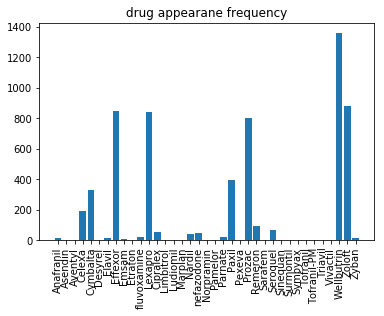

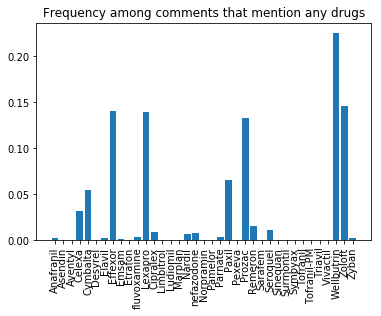

In [278]:
# Frequency of mentions of drugs 
%matplotlib inline

freq = []
labels = []
for  (k,v) in d_drug_ment_sub.items():
    freq.append(len(v))
    labels.append(k)
# Note plt.hist() won't work --> Bar is the right way 

#tick_label does the some work as plt.xticks()
plt.bar(range(len(freq)),freq,tick_label=labels)
plt.title('drug appearane frequency')
plt.xticks(rotation=90)
plt.savefig("Drug_mentioned.png")

#tick_label does the some work as plt.xticks()
print (np.array(freq).sum())
plt.figure()
plt.bar(range(len(freq)),freq/np.array(freq).sum(),tick_label=labels)
plt.title('Frequency among comments that mention any drugs')
plt.xticks(rotation=90)
plt.savefig("Frequency_drug_mentioned.png")

Note that submissions are significantly undersampled for certain drugs 

Let's take a look at the top five and top 10 mentioned drugs

In [279]:
top_5_drug_ment_sub = sorted(d_drug_ment_sub.items(), key=lambda x: len(x[1]),reverse=True)[0:5]
top_10_drug_ment_sub = sorted(d_drug_ment_sub.items(), key=lambda x: len(x[1]),reverse=True)[0:10]

In [282]:
top_5_drugs=  [x for (x,df) in top_5_drug_ment_sub]
print (top_5_drugs)

for (x,df) in top_5_drug_ment_sub:
    name = 'top5/'+x+'_top5_'+tag+source 
    d_drug_ment_sub[x].to_pickle(newpath_processed+"/%s.pkl"%(name))
   
top_10_drugs=  [x for (x,df) in top_10_drug_ment_sub]
for (x,df) in top_10_drug_ment_sub:
    name = 'top10/'x+'_top10_'+tag+source 
    d_drug_ment_sub[x].to_pickle(newpath_processed+"/%s.pkl"%(name))

['Wellbutrin', 'Zoloft', 'Effexor', 'Lexapro', 'Prozac']
Zyban
<class 'list'>
<class 'tuple'>
['Wellbutrin', 'Zoloft', 'Effexor', 'Lexapro', 'Prozac', 'Paxil', 'Cymbalta', 'Celexa', 'Remeron', 'Seroquel']
<class 'list'>
<class 'tuple'>


### 4. Sentiment analysis

1. Sentiment analysis: this is really a garbage here...
   -1.1 score accordingly to negative/neutral/positive 
       -1.1.1 However, for most of the drugs, sentiment score is overwhelmingly neural --> This needs to be improved; instead of sentiment analysis on the wholebody - try average by sentence?
       -1.1.2 Also, way too many garbage words here.. this may also have to be extracted 
2. Create dataframe of Top5 mentioned drugs/ top10 mentioned drugs: author, body, id, score (doesn't have any meaning here), selftext_by_sent, selftexgt_bywords, self_textbody, rating_score (from sentiment analysis on the whole body of the text)


Only take the commments metioning one drug in the comment and do the overall sentiment calculation
pitfall is, though, overall document score may not even that good - We may have to just look at one sentence before and after

To build some kinda of recommendation system, I need to have a score for each of the users 
Okay, let's do this then
Get the dominant sentiment of the given user
convert them to the score from 1-5: negative 1, neutral 2, positive 3 

How do you extract the overall sentiment? 
Extract the data, mentioning only one drug - - > then do the overall sentiment analysis 

In [290]:
message_text = "Personally it took me about 2 months to really notice a difference.', 'Like most people I’ve talked to though, I take it in combination with another antidepressant.', 'I’ve never taken it without something like Lexapro, Cymbalta (which does the exact same thing as Wellbutrin but is not stimulating) or Prozac.', 'In short, wait 4-6 and if you still can’t tell a difference see your doc."

sent, score= sentiment_analysis(message_text) # r is ordered dictionary 
numeric_score= sent_to_score(sent)
print (sent, score)


neu 3


In [291]:
 # Testing the tokenization scheme on A
# TESTING THIS PART 
# LOOK AT ME! 
name, df = top_5_drug_ment_sub[0]

df['selftext_bysent']= [[]] * len(df)
df['selftext_byWords']= [[]] * len(df)
total_txt_data= []
total_txt_word = []
print (df.head())
for i in df['body'].index[:2]:

    parsed = tokenizer.tokenize(df.at[i,'body'])
    df.at[i, 'selftext_bysent'] = parsed
    print (parsed)
    print (df.at[i, 'selftext_bysent'])
        
#   Parse into words - create list of lists 
    words= list(sent_to_words(df.at[i,'selftext_bysent']))
    words_flatten = [item for sublist in words for item in sublist]     
    df.at[i,'selftext_byWords'] = words_flatten
    total_txt_data.extend(tokenizer.tokenize(df.loc[i]['body'])[:])
   

           author                                               body       id  \
3   Taylor8675309  I've tried celexa, lexapro, brintellix, and we...  e63suvg   
22   madmax051820  Personally it took me about 2 months to really...  e62vaug   
24      mmlnola66  Wellbutrin 300XL and 40mg Prozac have been the...  e62b515   
32     nanotech23   I don't think it plays well with alcohol, but...  e61mu8b   
35      shinesy57  I was on wellbutrin on and off for 8 years (mo...  e61j8k3   

    score selftext_bysent selftext_byWords  
3       1              []               []  
22      1              []               []  
24      1              []               []  
32      1              []               []  
35      1              []               []  
["I've tried celexa, lexapro, brintellix, and wellbutrin.", 'Everything except wellbutrin has made me gain weight']
["I've tried celexa, lexapro, brintellix, and wellbutrin.", 'Everything except wellbutrin has made me gain weight']
['Personall

EDA on patients' experience corpora:
- See the most prevalent/rare wordss
- Distribution of sentence 
- Distribution of sentiment score

Note that I've refactored the analysis into a function(sentanal) to save figures and summary of the analysis.

In [ ]:
top5_drug_txt_parse,top_5_drug_ment_sub = sentanal(top_5_drug_ment_sub,newpath_1)
top10_drug_txt_parse,top_10_drug_ment_sub=  sentanal(top_10_drug_ment_sub,newpath_2)


In [ ]:
 The analysis in the functions are following:



Wellbutrin
count     109386
unique      5951
top          the
freq        3377
dtype: object
109386 words total, with a vocabulary size of 5951
Max sentence length is 522


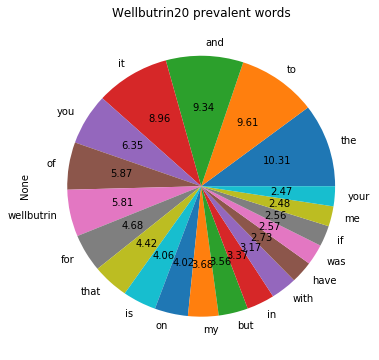

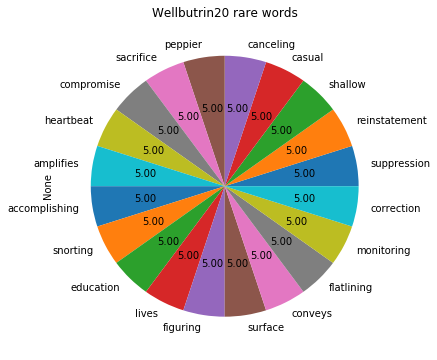

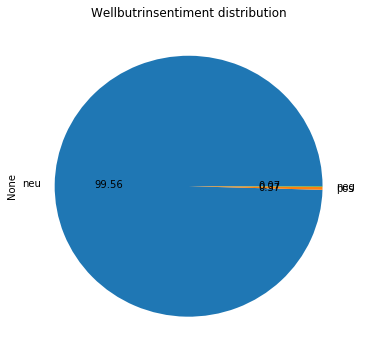

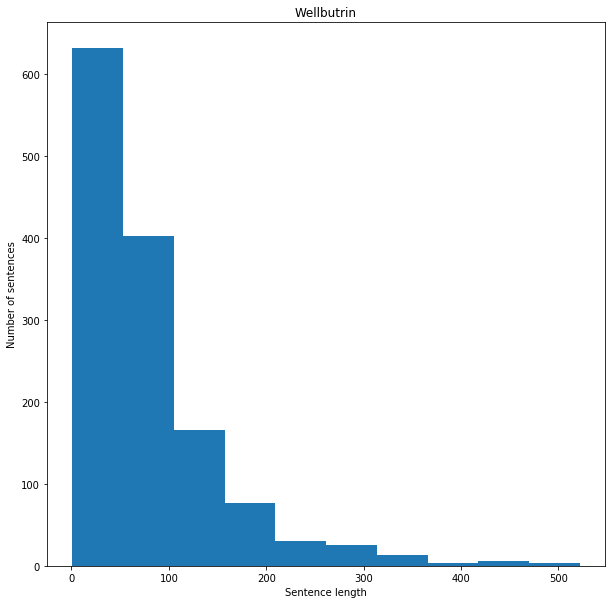



Zoloft
count     75921
unique     5237
top         the
freq       2270
dtype: object
75921 words total, with a vocabulary size of 5237
Max sentence length is 972


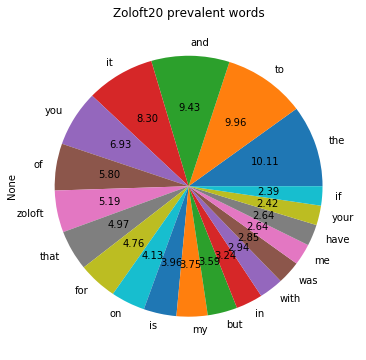

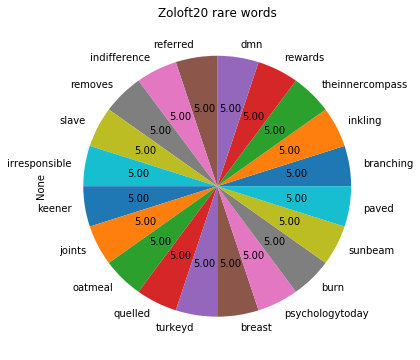

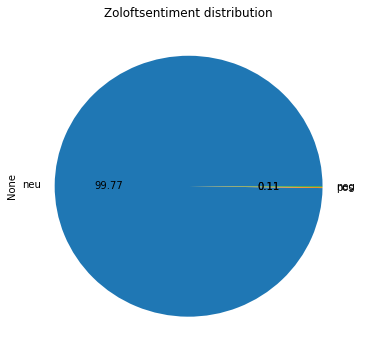

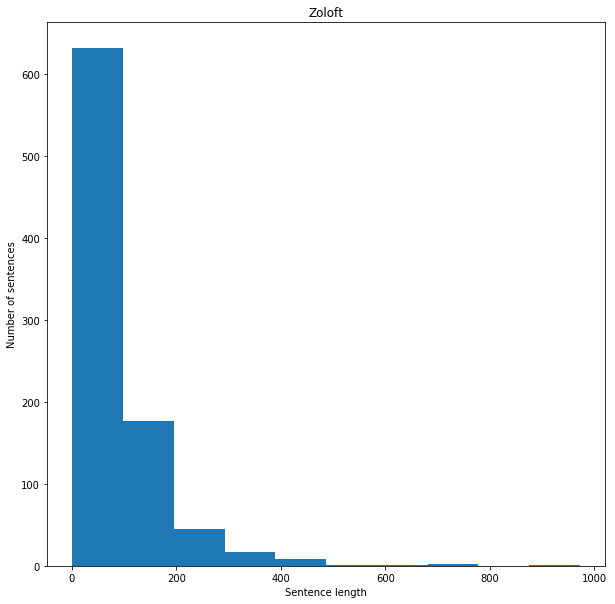



Effexor
count     80882
unique     5044
top          to
freq       2511
dtype: object
80882 words total, with a vocabulary size of 5044
Max sentence length is 1513


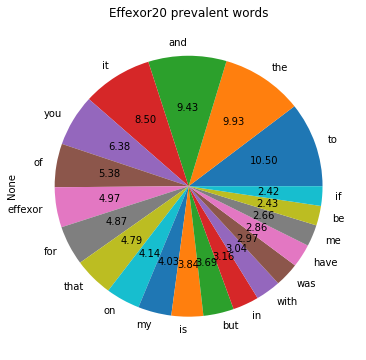

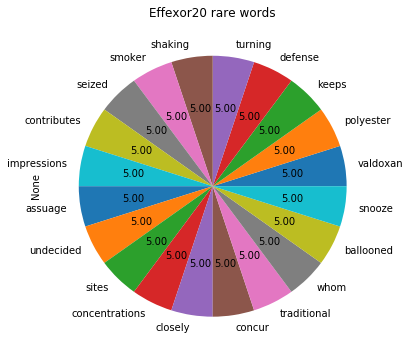

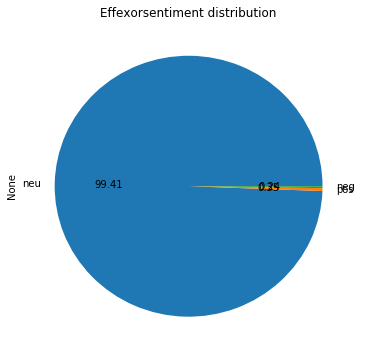

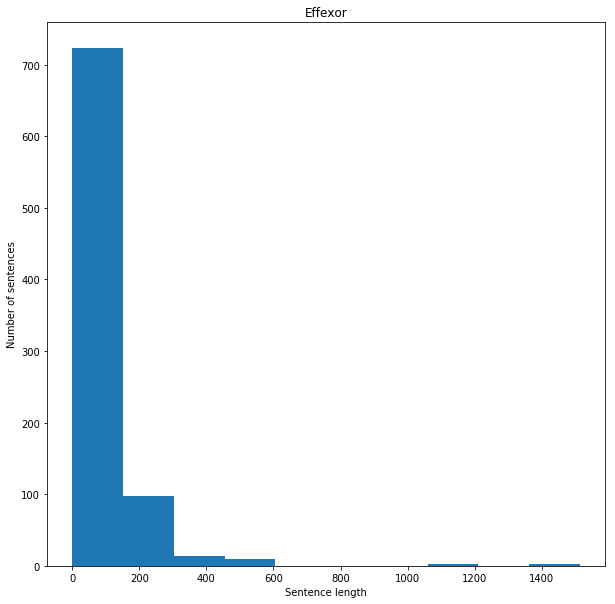



Lexapro
count     71744
unique     4861
top          to
freq       2242
dtype: object
71744 words total, with a vocabulary size of 4861
Max sentence length is 729


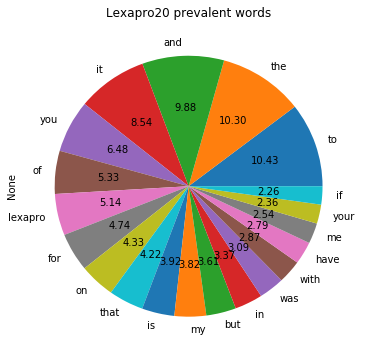

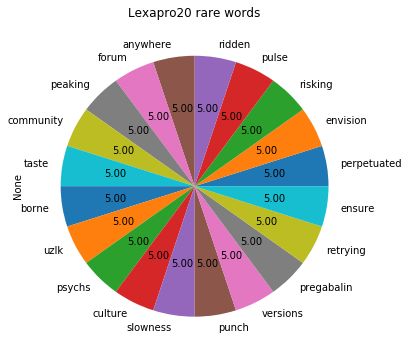

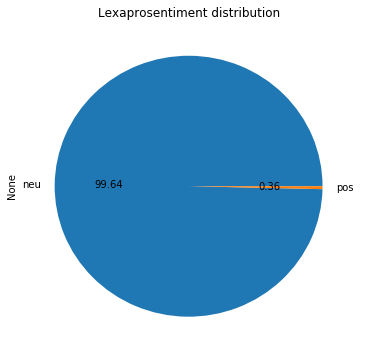

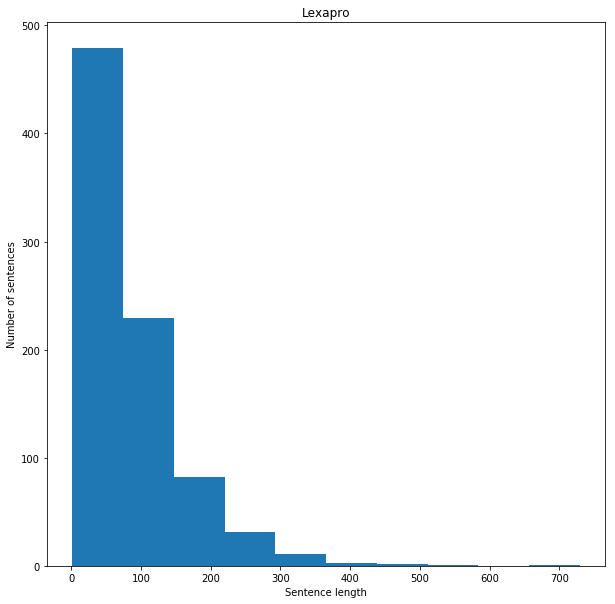



Prozac
count     72652
unique     4962
top         the
freq       2264
dtype: object
72652 words total, with a vocabulary size of 4962
Max sentence length is 1114


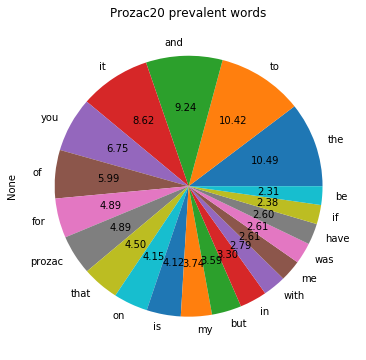

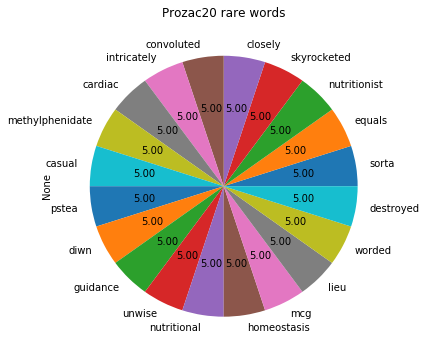

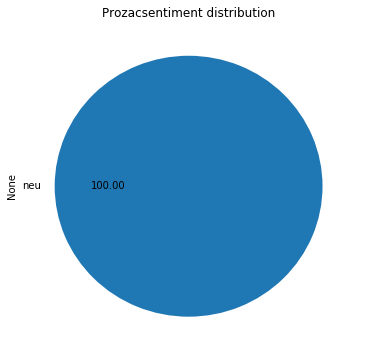

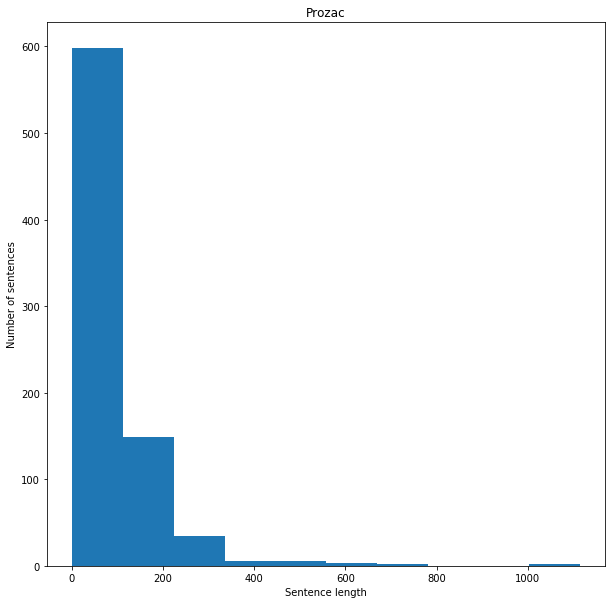

In [292]:
for drug_name, df in top_5_drug_ment_sub:
    print ('\n')
    print (drug_name)
    df['label'] = drug_name
    # Create new column of selt text parsed into sentences 
    df['selftext_bysent']= [[]] * len(df)
    df['selftext_byWords']= [[]] * len(df)
    df['sentiment_body']= [[]] * len(df)
    df['rating_body']= [[]] * len(df)
#     print (df.head())
    total_txt_data = [] # Sentence list
    total_txt_word = [] # words list
    
    for i in df['body'].index:
        
        # Parse into sentences
        parsed = tokenizer.tokenize(df.at[i,'body'])
        df.at[i,'selftext_bysent'] = parsed
        
        # Parse into words - create list of lists 
        words= list(sent_to_words(df.at[i,'selftext_bysent']))
        words_flatten = [item for sublist in words for item in sublist] 
        
        df.at[i,'selftext_byWords'] = words_flatten
        total_txt_word.extend(words_flatten )
        # total_txt has all sentences 
        total_txt_data.extend(tokenizer.tokenize(df.loc[i]['body'])[:])

        sent, score = sentiment_analysis(df.at[i,'body']) 
        df.at[i,'sentiment_body'] = sent
        df.at[i,'rating_body'] = score
    
    top5_drug_txt_parse[drug_name]=total_txt_data 
#     print ('drugname:')

    plt.figure()
    print (pd.Series(total_txt_word).describe())
    pd.Series(total_txt_word).value_counts().nlargest(20).plot.pie(autopct='%.2f', fontsize=10, figsize=(6, 6))
    plt.title(drug_name+"20 prevalent words")
    
    plt.figure()
    pd.Series(total_txt_word).value_counts().nsmallest(20).plot.pie(autopct='%.2f', fontsize=10, figsize=(6, 6))
    plt.title(drug_name+"20 rare words")
    
    plt.figure()
    pd.Series((df['sentiment_body'].values)).value_counts().plot.pie(autopct='%.2f', fontsize=10, figsize=(6, 6))
    plt.title(drug_name+"sentiment distribution")
    
    sentence_lengths = [len(tokens) for tokens in df["selftext_byWords"]]
    VOCAB = sorted(list(set(total_txt_word)))
    print("%s words total, with a vocabulary size of %s" % (len(total_txt_word), len(VOCAB)))
    print("Max sentence length is %s" % max(sentence_lengths))

    fig = plt.figure(figsize=(10, 10)) 
    plt.xlabel('Sentence length')
    plt.ylabel('Number of sentences')
    plt.hist(sentence_lengths)
    plt.title(drug_name)
    plt.show()

Shows that sentiment analysis cannot differentiate nuance of patient's experience and therefore need to be improved upon 

Save the corpora with sentiment rating into a pickle fle

In [ ]:
top_5_all_drugs_clean = pd.DataFrame(columns = ['author', 'body', 'id', 'score', 'selftext_bysent', 'selftext_byWords',
       'label','sentiment_body','rating_body'])
d_list = [m for (n,m)in top_5_drug_ment_sub]
for (n,m) in top_5_drug_ment_sub:
    print(m.columns)
    print(len(m))
    top_5_all_drugs_clean= top_5_all_drugs_clean.append(m)
    print (top_5_all_drugs_clean)

top_10_all_drugs_clean = pd.DataFrame(columns = ['author', 'body', 'id', 'score', 'selftext_bysent', 'selftext_byWords',
       'label','sentiment_body','rating_body'])
d_list = [m for (n,m)in top_10_drug_ment_sub]
for (n,m) in top_10_drug_ment_sub:
    top_10_all_drugs_clean= top_10_all_drugs_clean.append(m)

newpath_1 = r'%s//pickled_refactor_test//%s//top5' %(cwd,tag)
if not os.path.exists(newpath_1):
    os.makedirs(newpath_1)
nm = tag+ source
pickl_list_tupl(top_5_drug_ment_sub, nm, newpath_1)

if not os.path.exists(newpath_2):
    os.makedirs(newpath_2)
nm = tag + source
print("pickl_list_tupl")
pickl_list_tupl(top_10_drug_ment_sub, nm, newpath_2)


### 5. train the model with CV and sentiment analysis score 
1.1 Training with Bag-of-words features + logistic regression

In [245]:
list_corpus = top_5_all_drugs_clean["body"].tolist()
list_labels = top_5_all_drugs_clean["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
cv = CountVectorizer()
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

[ 1.7658095  -0.41489702 -0.14936573 ...  0.88640239 -2.22464449
 -3.10178158]
{'Prozac': 0, 'Lexapro': 1, 'Zoloft': 2, 'Effexor': 3, 'Wellbutrin': 4}


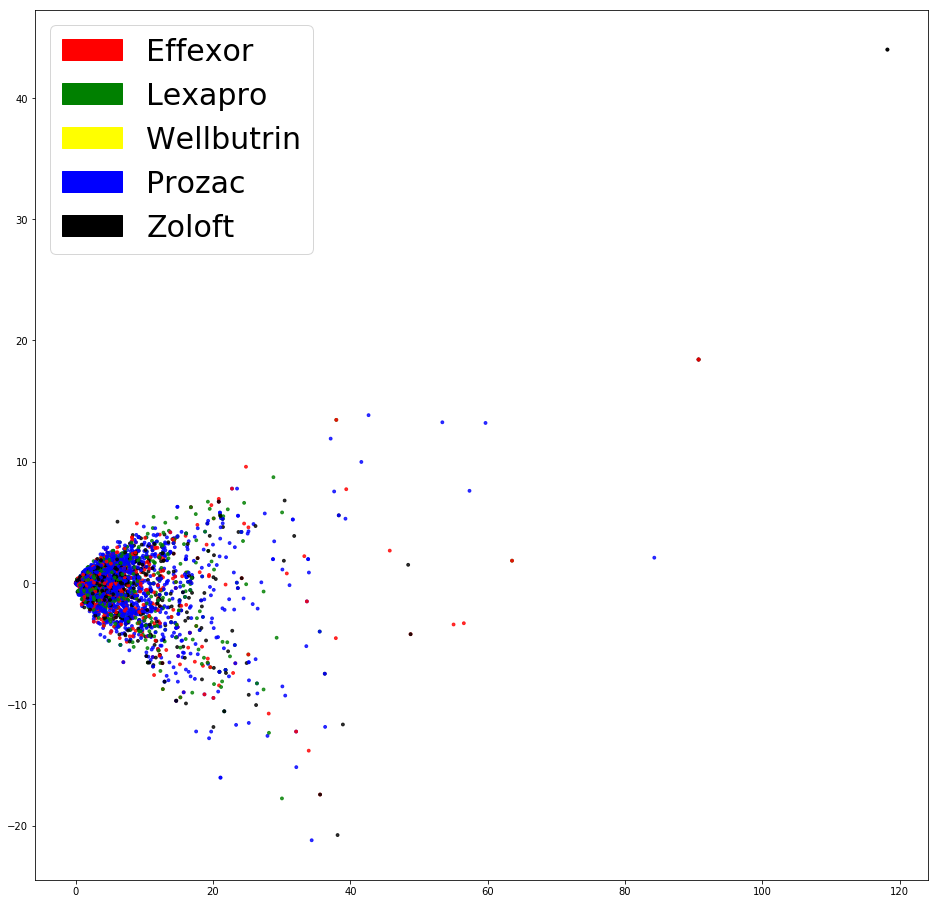

In [246]:
fig = plt.figure(figsize=(16, 16))      
plot_LSA(X_train_counts, y_train)
plt.savefig("LDA_BagOfWords.png")

In [247]:
# Logistic regression
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [249]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print(" = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

 = 0.632, precision = 0.636, recall = 0.632, f1 = 0.634


In [ ]:
labels =['Lexapro','Effexor','Wellbutrin','Prozac','Zoloft']
cm = confusion_matrix(y_test, y_predicted_counts, labels)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, normalize=True, title='Confusion matrix')
plt.show()
plt.savefig("LogisticRegression_cm.png")
print(cm)

1.2.1 Training with TF-IDF features + Linear SVC classifier

In [ ]:
top_5_all_drugs_clean['rating_body']= top_5_all_drugs_clean['rating_body'].astype(float)
mean_score = top_5_all_drugs_clean.groupby(['label'], as_index=False)['rating_body'].mean()
weight_dict = {k:v for (k,v) in mean_score.loc[:,['label','rating_body']].values}

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_transformed = tf_transformer.transform(X_train_counts)
X_test_transformed = tf_transformer.transform(X_test_counts)

labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
maps=list(labels.inverse_transform(range(len(labels.classes_))))
values=range(len(labels.classes_))
decodekeys= dict(zip(maps,values))
weight_dict_encoded = {decodekeys[k]:v for (k,v) in weight_dict.items()}

linear_svc = LinearSVC(class_weight = weight_dict_encoded)
clf = linear_svc.fit(X_train_transformed,y_train_lables_trf)

calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc,
                                        cv="prefit")

calibrated_svc.fit(X_train_transformed,y_train_lables_trf)
predicted = calibrated_svc.predict(X_test_transformed)

print('Average accuracy on test set={}'.format(np.mean(predicted == labels.transform(y_test))))
print('Predicted probabilities of demo input string are')
print(calibrated_svc.predict_proba(p_tfidf))

result = pd.DataFrame(calibrated_svc.predict_proba(p_tfidf)*100, columns=labels.classes_)
new = pd.melt(result,var_name='Drug name', value_name= 'likelihood(%)').round(2)
result_sorted =new.sort_values(by=['likelihood(%)'], ascending=False ).reset_index(drop=True)
result_sorted.rename(index= {0:'1st',1:'2nd',2:'3rd',3:'4th',4:'5th'}, inplace=True)
result_sorted.index.name= "Rank"
print (result_sorted)

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


1.2.2 Training with TF-IDF features + Logistic regression

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))
print(y_test[0:5])
print(y_predicted_tfidf[0:5])

In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, normalize=True, title='Confusion matrix')
plt.show()
print("TFIDF LR confusion matrix")
print(cm2)
print("TFIDF SVC confusion matrix")
print(conf_mat)
print("BoW LR confusion matrix")
print(cm)

TFIDF and Bag-of-words do not show discernable performance difference. This is inline with what we see from LSA plot - they the word features for anti-depressants don't separate much from one another. 

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

In [ ]:
for i in range(len(importance_tfidf)):
    top_scores = [a[0] for a in importance_tfidf[i]['tops']]
    top_words = [a[1] for a in importance_tfidf[i]['tops']]
    bottom_scores = [a[0] for a in importance_tfidf[i]['bottom']]
    bottom_words = [a[1] for a in importance_tfidf[i]['bottom']]
    title= importance[i]['name']
    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance", title)

1.3. Word2Vec feature + LR

In [296]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [305]:
embeddings = get_word2vec_embeddings(word2vec, top_5_all_drugs_clean)
missing = get_word2vec_missings(word2vec, top_5_all_drugs_clean)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [306]:
print (y_train_word2vec[:5])

['Wellbutrin', 'Effexor', 'Wellbutrin', 'Prozac', 'Prozac']


In [307]:
miss= pd.Series(missing)
miss_df= pd.DataFrame({ 'list':miss.values})

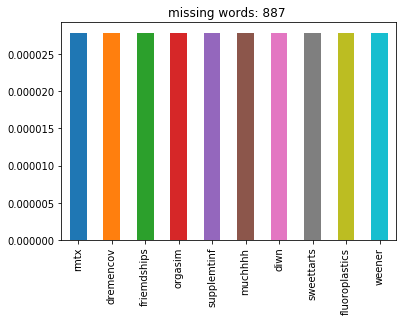

In [308]:
missed = miss_df.list.apply(pd.Series).stack().value_counts()

total_missed = missed.values.sum()
missed_divided = missed/total_missed
missed_divided[800:810].plot.bar()
plt.title("missing words: %d " %(len(missed)))
plt.savefig("word2vecmissingwords.png")

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [309]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',  multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

ValueError: setting an array element with a sequence.

In [112]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.739, precision = 0.745, recall = 0.739, f1 = 0.740


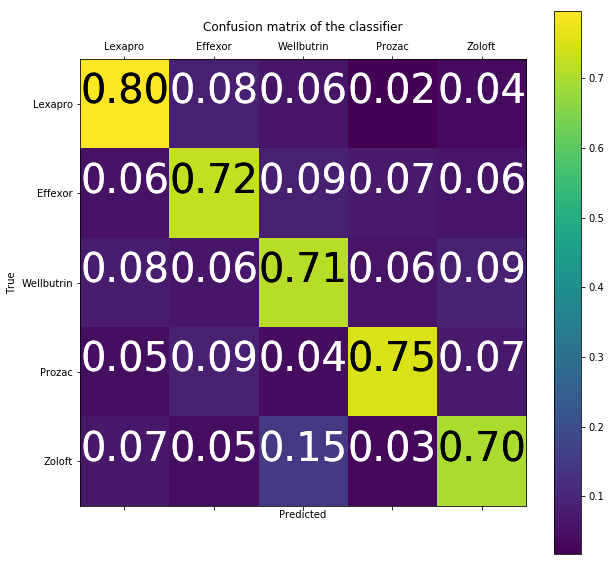

Word2Vec confusion matrix
[[141  15  11   3   7]
 [  9 118  14  12  10]
 [ 13  11 122  10  15]
 [ 12  23  11 197  19]
 [ 12   8  26   6 121]]
TFIDF confusion matrix
[[116  18  21  13   9]
 [ 17  91  20  23  12]
 [ 10  13 109  15  24]
 [ 17  29  17 177  22]
 [ 12  11  22  15 113]]
BoW confusion matrix
[[ 92  19  21  19  12]
 [ 23 113  12  21   8]
 [ 27  17 179  19  20]
 [ 16  12  15 105  23]
 [ 12  15  16  21 109]]


In [116]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v , normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec + LR confusion matrix")
print(cm_w2v)
print("TFIDF + LR confusion matrix")
print(cm2)
print("BoW +LR confusion matrix")
print(cm)

In [ ]:
# As demonstrated here, W2V + LR performed the best was chosen to be displayed in the web app